# Hyper Parameter Selection for Feature Selection 

In [207]:
import torch.nn.functional

from data_loading import load_data, create_dataloaders, split_dataset
import configuration
from modeling.Predictor import Predictor
from matplotlib import pyplot as plt
import numpy as np

data = load_data()

In [208]:
data = data[['Date', '_MKT']]

window_size = 52
num_features = data.shape[1] - 1
length_pred = 1
look_ahead = 13

train_set, val_set, test_set = split_dataset(data, 
                                             window_size=window_size, 
                                             prediction_length=length_pred, 
                                             look_ahead=look_ahead,
                                             scale_target=True,
                                             fixed_feature_size = None,
                                             is_indexed=True)

train_loader, val_loader, test_loader = create_dataloaders(train_set, val_set, test_set, shuffle_train_loader=True, batch_size=200)

In [209]:
from tqdm import tqdm
import copy
from models.LSTM import LSTM
from modeling.Trainer import Trainer
from models.CNN import CNN

model = CNN(window_size=window_size, 
            num_features=num_features,
            output_size=length_pred,
            kernel_size = 9, 
            num_conv=2,
            padding=True,
            channels=2,
            hidden_size=50,
            num_hidden_layers=2,
            dropout=0.1
            )

total_params = sum(p.numel() for p in model.parameters())
print("Parameter Count of Network:", total_params)


results_train = []
results_test = []
models = []

for i in tqdm(range(40)):

    trainer = Trainer(copy.deepcopy(model), 
                      epochs = 50,
                      learning_rate =  1e-4,
                      ) 
    
    trained_models, loss = trainer.train(train_loader, val_loader, print_out=False, return_loss=True, return_all_networks=True)
    models.append(trained_models)

    results_train.append(loss)


Parameter Count of Network: 5702


100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


In [210]:
def find_elbow_point(data):
    """
    Finds the elbow point from a list of numbers using the maximum distance method.
    
    Parameters:
        data (list or np.ndarray): The y-values of your curve.
        
    Returns:
        int: The index of the elbow point.
    """
    # Create an array of (x, y) points where x is the index
    n_points = len(data)
    all_points = np.column_stack((np.arange(n_points), data))
    
    # Line from first to last point
    first_point = all_points[0]
    last_point = all_points[-1]
    
    # Compute the normalized vector of the line
    line_vec = last_point - first_point
    line_vec_norm = line_vec / np.linalg.norm(line_vec)
    
    # Compute distances from each point to the line
    distances = []
    for point in all_points:
        # Vector from the first point to the current point
        vec_from_first = point - first_point
        # Projection scalar of vec_from_first onto the normalized line vector
        proj_length = np.dot(vec_from_first, line_vec_norm)
        proj_point = first_point + proj_length * line_vec_norm
        # Calculate the perpendicular distance
        distance = np.linalg.norm(point - proj_point)
        distances.append(distance)
    
    # The elbow is the point with maximum distance
    elbow_index = np.argmax(distances)
    return elbow_index

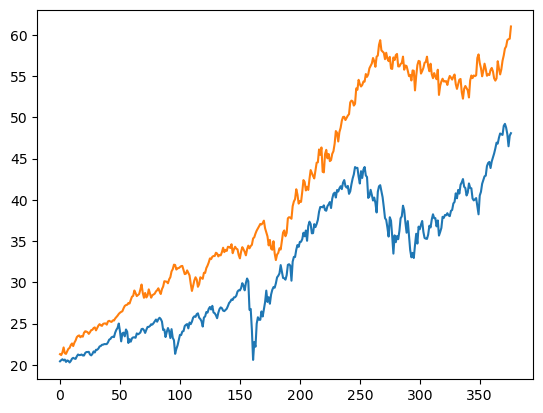

In [211]:
networks = []

mse_train = []
mse_test = []
mae_test = []
mse_val = []

for i in range(len(models)):
    mse_values = results_train[i]
    
    mse_train_values = [v[0] for v in mse_values]
    mse_val_values = [v[1] for v in mse_values]
    
    elbow_index = find_elbow_point(mse_train_values)
    elbow_index += 5
    
    mse_train.append(mse_train_values[elbow_index])
    mse_val.append(mse_val_values[elbow_index])
    

    selected_model = models[i][elbow_index]
    
    predictions, targets = Predictor(selected_model).predict(test_loader)
    if i == 1:
        plt.figure()
        x = range(len(targets))
        plt.plot(x, targets)
        plt.plot(x, predictions)
        plt.show()
    
    mse = torch.nn.functional.mse_loss(torch.tensor(predictions), torch.tensor(targets)).item()
    mae = torch.nn.functional.l1_loss(torch.tensor(predictions), torch.tensor(targets)).item()
    
    mse_test.append(mse)
    mae_test.append(mae)
    
    

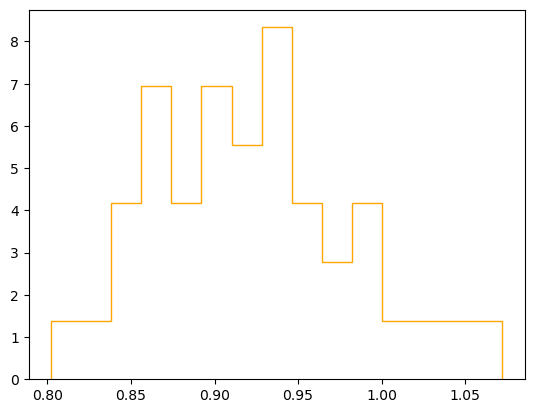

In [212]:

plt.hist(mse_train, bins=15, density=True, histtype = 'step', color = 'orange')
plt.show()

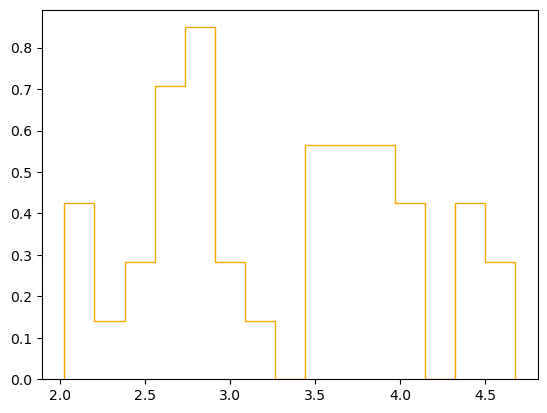

In [213]:
plt.hist(mse_val, bins=15, density=True, histtype = 'step', color = 'orange')
plt.show()

In [214]:
sum(mse_val) / len(mse_val)

3.301792877469834

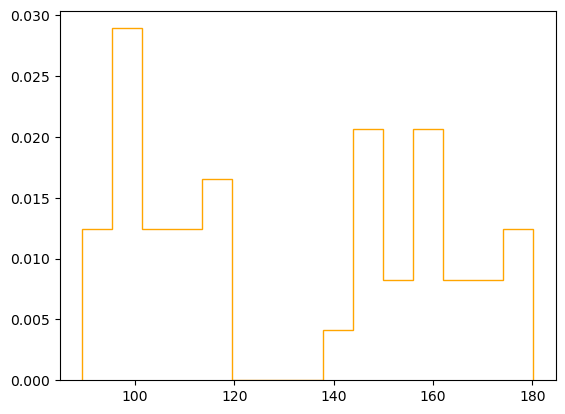

In [215]:
plt.hist(mse_test, bins=15, density=True, histtype = 'step', color = 'orange')
plt.show()

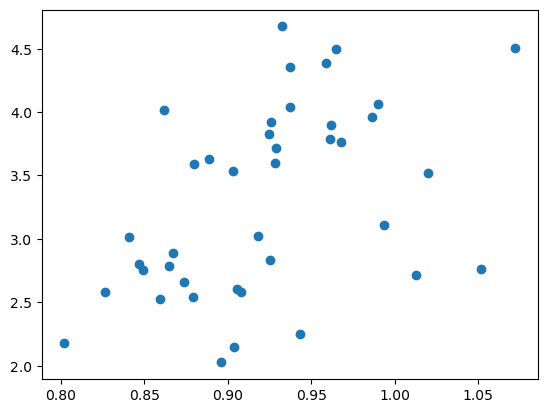

In [216]:
plt.scatter(mse_train, mse_val)
plt.show()

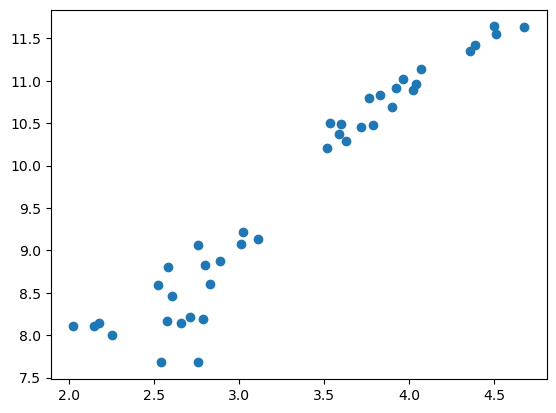

In [217]:
plt.scatter(mse_val, mae_test)
plt.show()

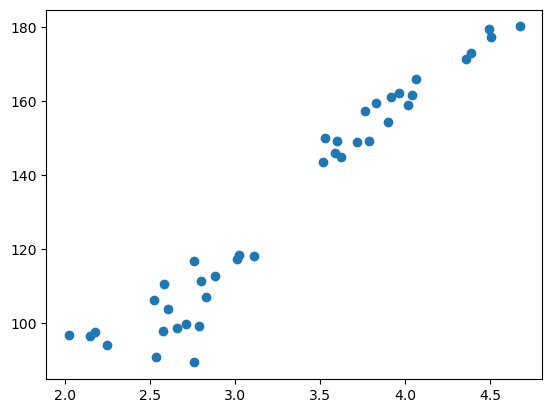

In [218]:
plt.scatter(mse_val, mse_test)
plt.show()